In [1]:
# Import necessary libraries for numerical computations, data processing, and model building
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
import pandas as pd  # Used for data manipulation and analysis. Provides data structures like DataFrames to handle data efficiently.
import matplotlib.pyplot as plt  # Used for creating static, animated, and interactive visualizations in Python. Specifically, for plotting graphs like loss curves, accuracy, and other metrics.
import tensorflow as tf  # A comprehensive library for deep learning, including support for neural networks, training models, and more.

# Import specific Keras layers to build the neural network architecture
from tensorflow.keras.models import Sequential  # Sequential model type for stacking layers in a linear fashion (layer by layer).
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
  # Conv2D: Applies 2D convolution operations (essential for image-based tasks).
  # MaxPooling2D: Applies max-pooling operation to down-sample spatial dimensions (reduce computational load and prevent overfitting).
  # Flatten: Converts 2D matrix (feature map) to 1D vector to pass to Dense layers.
  # Dense: Fully connected layer that helps the network to learn from high-level features.
  # Dropout: Regularization method to prevent overfitting by randomly dropping units during training.
  # BatchNormalization: Normalizes the activations of the previous layers to improve training speed and stability.

# Import Adam optimizer for model optimization
from tensorflow.keras.optimizers import Adam  # Adam optimizer is a popular adaptive learning rate optimization algorithm. It is efficient for training deep learning models.



In [2]:
np.random.seed(42)  # Set the seed for NumPy's random number generator. This ensures that all random operations (like shuffling, sampling, or generating random numbers) produce the same result every time the code is run. This is essential for reproducibility.

tf.random.set_seed(42)  # Set the seed for TensorFlow's random number generator. Similar to NumPy, this ensures that any random operations in TensorFlow (such as weight initialization or data shuffling) are consistent across runs, promoting reproducibility.


In [3]:
# Function to load the EMNIST dataset (Extended MNIST) from a local source or by downloading it from a URL.
def load_emnist_data():
    data_dir = './data/emnist'  # Define directory to store the EMNIST dataset
    os.makedirs(data_dir, exist_ok=True)  # Create the directory if it doesn't already exist

    # Define the URL to download the EMNIST dataset (byclass variant contains 62 classes)
    base_url = 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'

    # Check if the dataset has already been downloaded. If not, download and extract it.
    if not os.path.exists(os.path.join(data_dir, 'emnist-byclass-train-images-idx3-ubyte')):
        print("Downloading EMNIST dataset (this may take a while)...")

        # Download the zip file containing the EMNIST dataset
        response = requests.get(base_url)
        zip_path = os.path.join(data_dir, 'emnist.zip')
        with open(zip_path, 'wb') as f:
            f.write(response.content)  # Save the zip file

        # Extract the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)  # Extract all files to the data directory

        # Extract gzip files (the actual data files)
        gzip_dir = os.path.join(data_dir, 'gzip')
        for gz_file in os.listdir(gzip_dir):
            if gz_file.startswith('emnist-byclass'):
                gz_path = os.path.join(gzip_dir, gz_file)
                output_path = os.path.join(data_dir, gz_file[:-3])  # Remove .gz extension from file name
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(output_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)  # Decompress the gzipped file

    # Paths to the extracted image and label files
    train_images_path = os.path.join(data_dir, 'emnist-byclass-train-images-idx3-ubyte')
    train_labels_path = os.path.join(data_dir, 'emnist-byclass-train-labels-idx1-ubyte')
    test_images_path = os.path.join(data_dir, 'emnist-byclass-test-images-idx3-ubyte')
    test_labels_path = os.path.join(data_dir, 'emnist-byclass-test-labels-idx1-ubyte')

    # Convert the IDX file format (binary format used by EMNIST) to NumPy arrays
    print("Converting IDX files to NumPy arrays...")
    X_train = idx2numpy.convert_from_file(train_images_path)
    y_train = idx2numpy.convert_from_file(train_labels_path)
    X_test = idx2numpy.convert_from_file(test_images_path)
    y_test = idx2numpy.convert_from_file(test_labels_path)

    # EMNIST images need to be rotated and flipped for proper orientation
    X_train = np.rot90(np.fliplr(X_train.reshape(-1, 28, 28)), 1, (1, 2))  # Rotate and flip training images
    X_test = np.rot90(np.fliplr(X_test.reshape(-1, 28, 28)), 1, (1, 2))  # Rotate and flip test images

    # Reshape images to add a channel dimension (for grayscale) and normalize pixel values
    X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Split training data into training and validation sets (90% for training, 10% for validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Print dataset information to confirm successful loading
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Number of classes: {len(np.unique(y_train))}")  # Print the number of unique classes in the training labels

    return X_train, y_train, X_val, y_val, X_test, y_test

# Alternative function to load EMNIST dataset using TensorFlow datasets (if available)
def load_emnist_from_tensorflow():
    try:
        print("Loading EMNIST dataset from TensorFlow...")  # Attempt to load the dataset using TensorFlow Datasets (TFDS)
        import tensorflow_datasets as tfds  # Import TensorFlow datasets module

        # Load the EMNIST dataset (byclass variant)
        ds_train, ds_test = tfds.load('emnist/byclass', split=['train', 'test'], as_supervised=True)

        # Function to preprocess images (normalizing to the range [0, 1])
        def preprocess(image, label):
            image = tf.cast(image, tf.float32) / 255.0  # Normalize the image pixel values to [0, 1]
            return image, label  # Return the processed image and label

        # Apply preprocessing to the training and test datasets
        ds_train = ds_train.map(preprocess)
        ds_test = ds_test.map(preprocess)

        # Convert datasets to NumPy arrays
        X_train = []
        y_train = []
        for image, label in tfds.as_numpy(ds_train):
            X_train.append(image)
            y_train.append(label)

        X_test = []
        y_test = []
        for image, label in tfds.as_numpy(ds_test):
            X_test.append(image)
            y_test.append(label)

        # Convert lists to NumPy arrays
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Split training data into training and validation sets (90% for training, 10% for validation)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        return X_train, y_train, X_val, y_val, X_test, y_test  # Return the processed datasets

    except Exception as e:
        print(f"Error loading from TensorFlow datasets: {e}")  # Handle any exceptions that occur during the loading process
        return None, None, None, None, None, None  # Return None if there's an error


In [ ]:
# Function to load the EMNIST dataset (or fallback to MNIST if EMNIST loading fails)
def load_data():
    try:
        # Try to load the EMNIST dataset using the load_emnist_data function
        X_train, y_train, X_val, y_val, X_test, y_test = load_emnist_data()
        return X_train, y_train, X_val, y_val, X_test, y_test  # Return loaded EMNIST data

    except Exception as e:
        # If there's an error loading the EMNIST dataset, print the error message
        print(f"Error loading EMNIST directly: {e}")

        try:
            # Try to load the EMNIST dataset from TensorFlow datasets (TFDS)
            X_train, y_train, X_val, y_val, X_test, y_test = load_emnist_from_tensorflow()
            if X_train is not None:
                return X_train, y_train, X_val, y_val, X_test, y_test  # Return loaded EMNIST data from TFDS
        except Exception as e:
            # If there's an error loading from TensorFlow datasets, print the error message
            print(f"Error loading from TensorFlow datasets: {e}")

        # Fallback to loading the MNIST dataset if EMNIST or TFDS loading fails
        print("Falling back to standard MNIST dataset (digits only)...")
        from tensorflow.keras.datasets import mnist  # Import the standard MNIST dataset

        # Load the MNIST dataset (which contains digits 0-9)
        (X_train, y_train), (X_test, y_test) = mnist.load_data()

        # Reshape and normalize the MNIST data (reshape to include channel dimension and normalize pixel values)
        X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        # Split the training data into training and validation sets (90% training, 10% validation)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        return X_train, y_train, X_val, y_val, X_test, y_test  # Return MNIST data



In [ ]:
# Function to get the class mapping for the EMNIST 'byclass' dataset (62 classes)
def get_class_mapping():
    # Define the character sets for EMNIST classes:
    # - Classes 0-9: digits 0-9
    # - Classes 10-35: uppercase letters A-Z
    # - Classes 36-61: lowercase letters a-z
    digits = [str(i) for i in range(10)]  # List of strings representing digits 0-9
    uppercase = list(string.ascii_uppercase)  # List of uppercase letters A-Z
    lowercase = list(string.ascii_lowercase)  # List of lowercase letters a-z

    # Create an empty dictionary to store class mappings
    class_mapping = {}

    # Map the class indices (0-61) to their respective characters
    for i in range(62):  # There are 62 classes in total (0-61)
        if i < 10:  # Classes 0-9 represent digits
            class_mapping[i] = digits[i]  # Map to corresponding digit (0-9)
        elif i < 36:  # Classes 10-35 represent uppercase letters
            class_mapping[i] = uppercase[i-10]  # Map to corresponding uppercase letter (A-Z)
        else:  # Classes 36-61 represent lowercase letters
            class_mapping[i] = lowercase[i-36]  # Map to corresponding lowercase letter (a-z)

    # Return the generated class mapping dictionary
    return class_mapping


In [4]:
# Function to create a Convolutional Neural Network (CNN) model for classification
def create_model(num_classes):
    # Create a sequential model
    model = Sequential([

        # -----------------------------------------------------------
        # First Convolutional Block: Extract features from input images
        # -----------------------------------------------------------
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),  # First Conv Layer
        BatchNormalization(),  # Normalize activations to speed up convergence
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),  # Second Conv Layer
        BatchNormalization(),  # Normalize activations
        MaxPooling2D(pool_size=(2, 2)),  # Downsample the spatial dimensions
        Dropout(0.25),  # Dropout layer to prevent overfitting (25% of neurons are dropped)

        # -----------------------------------------------------------
        # Second Convolutional Block: Extract more complex features
        # -----------------------------------------------------------
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),  # First Conv Layer of Block 2
        BatchNormalization(),  # Normalize activations
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),  # Second Conv Layer of Block 2
        BatchNormalization(),  # Normalize activations
        MaxPooling2D(pool_size=(2, 2)),  # Downsample the spatial dimensions
        Dropout(0.25),  # Dropout to prevent overfitting

        # -----------------------------------------------------------
        # Third Convolutional Block: Extract more abstract features
        # -----------------------------------------------------------
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),  # First Conv Layer of Block 3
        BatchNormalization(),  # Normalize activations
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),  # Second Conv Layer of Block 3
        BatchNormalization(),  # Normalize activations
        MaxPooling2D(pool_size=(2, 2)),  # Downsample the spatial dimensions
        Dropout(0.25),  # Dropout to prevent overfitting

        # -----------------------------------------------------------
        # Fully Connected Layers: Learn high-level representations
        # -----------------------------------------------------------
        Flatten(),  # Flatten 3D output from convolutional blocks into a 1D array
        Dense(512, activation='relu'),  # Fully connected layer with 512 neurons
        BatchNormalization(),  # Normalize activations to improve training
        Dropout(0.5),  # Dropout with a higher rate to prevent overfitting
        Dense(256, activation='relu'),  # Fully connected layer with 256 neurons
        BatchNormalization(),  # Normalize activations
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation (num_classes units)
    ])

    # Compile the model with the Adam optimizer and sparse categorical crossentropy loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
        loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
        metrics=['accuracy']  # Evaluate accuracy as the metric during training and evaluation
    )

    return model  # Return the constructed model


Let's take a deep dive into the architecture. I'll break down each component of the Convolutional Neural Network (CNN) step by step, explaining the purpose, functioning, and significance of each layer, along with the activation functions used and their mathematical representations.

---

### **1. Conv2D (Convolutional Layer)**

**Function:**

* The `Conv2D` layer applies a 2D convolution operation to the input image, extracting spatial features (e.g., edges, textures, or more complex patterns in higher layers). A set of filters (kernels) slides across the input image to capture these features.

**How it works:**

* **Filters/Kernels:** A filter is a small matrix (e.g., 3x3 or 5x5) that is convolved over the input image. The filter is learned during training. For each location on the image, the filter is multiplied by the input pixel values and summed to produce a single output value. This process is repeated for every position in the input image.

* **Padding:** In your architecture, `padding='same'` means that the output feature map will have the same width and height as the input. Padding zeros are added to the borders of the image to ensure that the spatial dimensions are preserved. This is in contrast to `"valid"` padding, which doesn't add padding and may reduce the size of the output feature map.

**Mathematical Representation:**

* The convolution operation is mathematically represented as:

  $$
  \text{Output}(i, j) = \sum_{k=0}^{m-1} \sum_{l=0}^{n-1} \text{Input}(i+k, j+l) \cdot \text{Kernel}(k, l)
  $$

  Where:

  * $\text{Output}(i, j)$ is the output feature map at location $(i, j)$.
  * $\text{Input}(i+k, j+l)$ is the input image at the location $(i+k, j+l)$.
  * $\text{Kernel}(k, l)$ is the filter applied to the input image.

---

### **2. BatchNormalization**

**Function:**

* **Batch normalization** normalizes the output of the previous layer (before the activation function) by adjusting and scaling activations. It helps mitigate issues like internal covariate shift (shifting distributions of inputs to each layer during training) and accelerates training by stabilizing learning.

**How it works:**

* It normalizes the input to the layer by centering it (subtracting the mean) and scaling it (dividing by the standard deviation). After normalization, learnable parameters (scale and shift) are applied to adjust the activations.

**Mathematical Representation:**

* Let $x$ be the input to the layer, the batch normalization output is:

  $$
  \hat{x} = \frac{x - \mu}{\sigma}
  $$

  Where:

  * $\mu$ is the mean of the input batch.
  * $\sigma$ is the standard deviation of the input batch.
  * After normalization, the output is scaled and shifted:

  $$
  y = \gamma \hat{x} + \beta
  $$

  Where:

  * $\gamma$ is the learned scale parameter.
  * $\beta$ is the learned shift parameter.

---

### **3. MaxPooling2D (Max Pooling Layer)**

**Function:**

* The `MaxPooling2D` layer reduces the spatial dimensions of the feature map (height and width). It does this by downsampling the image, using the maximum value in each region (usually a 2x2 window).

**How it works:**

* It slides a 2x2 window over the feature map and for each window, outputs the maximum value within that window. This operation reduces the resolution of the feature map, thus reducing the number of parameters and computations required, while preserving important features.

**Mathematical Representation:**

* Let the pooling window size be 2x2, the output value for a given region would be:

  $$
  \text{Output}(i, j) = \max(\text{Input}(i, j), \text{Input}(i+1, j), \text{Input}(i, j+1), \text{Input}(i+1, j+1))
  $$

---

### **4. Dropout Layer**

**Function:**

* The `Dropout` layer is a regularization technique to prevent overfitting. It randomly sets a fraction of input units to 0 during training, forcing the model to rely on different parts of the network.

**How it works:**

* During each forward pass, a proportion of neurons is "dropped" (set to zero) at each layer. The fraction is controlled by the dropout rate (e.g., 0.25 or 0.5).

**Significance:**

* Dropout prevents the network from becoming too dependent on any individual neuron, thereby helping the model generalize better to unseen data.

**Mathematical Representation:**

* The output $y$ of a neuron with input $x$ and dropout rate $p$ is:

  $$
  y = \begin{cases}
  0 & \text{with probability } p \\
  \frac{x}{1-p} & \text{with probability } 1-p
  \end{cases}
  $$

  Where $p$ is the dropout rate, and $x$ is the original input to the neuron.

---

### **5. Dense (Fully Connected) Layer**

**Function:**

* The `Dense` layer connects each neuron to every neuron in the previous layer. These layers are used for decision-making in the final stages of the network, once the feature extraction has been completed by convolutional and pooling layers.

**How it works:**

* Each neuron in the dense layer computes a weighted sum of its inputs, adds a bias term, and then applies an activation function.

**Mathematical Representation:**

* Let $x$ be the input, $w$ the weight, and $b$ the bias, the output of a neuron is:

  $$
  z = w^T x + b
  $$

  Where:

  * $w$ is the weight vector.
  * $x$ is the input vector.
  * $b$ is the bias term.
    The output is then passed through an activation function.

---

### **6. Activation Functions (ReLU and Softmax)**

#### **ReLU (Rectified Linear Unit)**

**Function:**

* ReLU is an activation function that introduces non-linearity to the network. It outputs the input directly if it's positive; otherwise, it outputs zero. This makes the network more capable of learning complex patterns.

**Mathematical Representation:**

* The ReLU function is:

  $$
  \text{ReLU}(x) = \max(0, x)
  $$

  Where $x$ is the input.

**Why ReLU?**

* It's computationally efficient and helps prevent the vanishing gradient problem (which can occur with sigmoid or tanh activation functions in deeper networks).

#### **Softmax (for Output Layer)**

**Function:**

* Softmax is used in the output layer of multi-class classification problems to convert the raw scores (logits) into probabilities. It scales the output values so that they sum to 1, representing the likelihood of each class.

**Mathematical Representation:**

* The softmax function is applied to the output vector $z = [z_1, z_2, ..., z_n]$ (logits) as follows:

  $$
  \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
  $$

  Where:

  * $z_i$ is the score for class $i$.
  * The denominator is the sum of exponentiated scores for all classes, ensuring the output values sum to 1.

**Why Softmax?**

* It converts the network's raw outputs into probabilities, which are easier to interpret. Each class’s probability represents the model's confidence in that particular class.

---

### **Final Summary of Layers:**

1. **Convolutional Layers (Conv2D):**

   * Learn spatial features from the input image.
   * Activation: **ReLU** (helps the network model complex relationships).
2. **Batch Normalization:**

   * Normalizes the activations, speeding up training and improving convergence.
3. **MaxPooling2D:**

   * Reduces the spatial size, making the network more computationally efficient.
4. **Dropout:**

   * Prevents overfitting by randomly dropping a fraction of neurons during training.
5. **Dense Layers:**

   * Fully connected layers that make the final predictions based on learned features.
6. **Softmax (Output Layer):**

   * Converts the network's final output into class probabilities.

---

This architecture is designed to progressively extract features from the input image, reduce its dimensionality, and ultimately make a classification decision based on the learned features. The use of ReLU, Batch Normalization, MaxPooling, and Dropout helps in training efficiency and avoiding overfitting, while the Softmax function ensures that the final output is interpretable as class probabilities.


In [ ]:
def create_data_generators(X_train, y_train, X_val, y_val):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1
    )

    # No augmentation for validation
    val_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=128)

    return train_generator, val_generator


In [ ]:
def create_data_generators(X_train, y_train, X_val, y_val):
    # Data augmentation for training
    # ImageDataGenerator is a Keras utility that allows us to generate batches of tensor data with real-time augmentation.
    # It is used to augment training data to help prevent overfitting by applying random transformations on the training images.

    train_datagen = ImageDataGenerator(
        # rotation_range: Randomly rotate the images by an angle between -10 and 10 degrees.
        # This allows the model to be invariant to rotations of the input images.
        rotation_range=10,

        # width_shift_range: Randomly shift the images horizontally (left or right) by up to 10% of the image width.
        # This helps the model learn to recognize objects regardless of their horizontal position in the image.
        width_shift_range=0.1,

        # height_shift_range: Randomly shift the images vertically (up or down) by up to 10% of the image height.
        # This helps the model become invariant to the vertical position of objects.
        height_shift_range=0.1,

        # zoom_range: Randomly zoom in or out by up to 10%. This helps the model generalize to different object sizes.
        zoom_range=0.1,

        # shear_range: Randomly apply shearing transformation by up to 10%. Shearing distorts the image, helping the model generalize better.
        shear_range=0.1
    )

    # No augmentation for validation
    # For the validation dataset, we don't apply any transformations. This ensures that the validation set is consistent
    # and serves as a fair evaluation of the model's performance.
    val_datagen = ImageDataGenerator()

    # Create generators
    # The .flow() function generates batches of images and labels from the provided data (X_train, y_train) or (X_val, y_val).
    # These batches are fed to the model during training or evaluation. We specify the batch_size as 128.

    train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
    # This creates a generator for the training set, applying the augmentations defined earlier on each batch.

    val_generator = val_datagen.flow(X_val, y_val, batch_size=128)
    # This creates a generator for the validation set, without any augmentations applied. Validation data is just used
    # to evaluate the model, so it remains unaltered to avoid bias.

    # Return the generators
    return train_generator, val_generator


In [ ]:
def evaluate_model(model, X_test, y_test, class_mapping=None):
    # Evaluate on the test set
    # The model.evaluate() function returns the loss value and accuracy metric of the model on the test data.
    # verbose=0 means no progress bar is displayed during evaluation.
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")  # Print the test accuracy value

    # Generate predictions
    # model.predict() returns the predicted probabilities for each class.
    # np.argmax() is used to convert the predicted probabilities into class labels (the index with the highest probability).
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Generate and print the classification report
    # classification_report() from scikit-learn provides a summary of precision, recall, f1-score, and support for each class.
    # If class_mapping is provided, the class names will be used; otherwise, integer class labels will be used.
    print("\nClassification Report:")
    if class_mapping:
        target_names = [class_mapping[i] for i in range(len(class_mapping))]
        print(classification_report(y_test, y_pred, target_names=target_names))  # Print report with class names
    else:
        print(classification_report(y_test, y_pred))  # Print report with class labels

    # Generate confusion matrix (only for a subset of classes if there are too many)
    # The confusion matrix shows the true vs predicted class counts.
    # Since there could be many classes, the matrix is limited to a subset (up to 20 classes) for visualization.
    num_classes = min(20, len(np.unique(y_test)))  # Limit to top 20 classes for the confusion matrix

    # Select a subset of the test data for confusion matrix visualization
    indices = []  # List to hold indices of test data for selected classes
    for class_idx in range(num_classes):
        class_indices = np.where(y_test == class_idx)[0]  # Get indices of samples belonging to each class
        if len(class_indices) > 0:
            indices.extend(class_indices[:50])  # Take up to 50 samples per class

    indices = np.array(indices)
    cm = confusion_matrix(y_test[indices], y_pred[indices], labels=range(num_classes))  # Compute confusion matrix

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Visualize confusion matrix using a color map
    plt.title('Confusion Matrix (Top 20 Classes)')
    plt.colorbar()  # Show color scale

    if class_mapping:
        classes = [class_mapping[i] for i in range(num_classes)]  # Use class names if provided
    else:
        classes = np.arange(num_classes)  # Use class labels (numeric) if class mapping is not provided

    tick_marks = np.arange(num_classes)  # Set tick marks for the x and y axes
    plt.xticks(tick_marks, classes, rotation=45)  # Rotate x-axis labels for better readability
    plt.yticks(tick_marks, classes)

    # Add text annotations to each cell of the confusion matrix
    thresh = cm.max() / 2.  # Set threshold for text color (white or black)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),  # Display the count in each cell
                     horizontalalignment="center",  # Center the text in the cell
                     color="white" if cm[i, j] > thresh else "black")  # Choose text color based on value

    plt.tight_layout()  # Adjust layout to make space for labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()  # Display confusion matrix

    # Plot some example predictions
    plt.figure(figsize=(12, 12))
    for i in range(25):  # Show 25 example images from the test set
        plt.subplot(5, 5, i+1)  # Create a 5x5 grid of subplots
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')  # Display the image (reshape to 28x28)
        true_label = y_test[i]  # True label of the image
        pred_label = y_pred[i]  # Predicted label from the model

        # If class_mapping is provided, display class names; otherwise, use numeric labels
        if class_mapping:
            true_char = class_mapping.get(true_label, str(true_label))
            pred_char = class_mapping.get(pred_label, str(pred_label))
            plt.title(f"True: {true_char}, Pred: {pred_char}")
        else:
            plt.title(f"True: {true_label}, Pred: {pred_label}")

        plt.axis('off')  # Hide axes
    plt.tight_layout()  # Adjust layout for neatness
    plt.show()  # Display the images

    return test_acc, y_pred  # Return test accuracy and predicted labels


# Function to save the model
def save_model(model, filepath='handwritten_recognition_model.h5'):
    model.save(filepath)  # Save the trained model to a file
    print(f"Model saved to {filepath}")  # Notify the user that the model was saved


# Function to visualize training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)  # Create a subplot for accuracy
    plt.plot(history.history['accuracy'])  # Plot training accuracy
    plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')  # Add legend for accuracy

    # Plot training & validation loss
    plt.subplot(1, 2, 2)  # Create a subplot for loss
    plt.plot(history.history['loss'])  # Plot training loss
    plt.plot(history.history['val_loss'])  # Plot validation loss
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')  # Add legend for loss

    plt.tight_layout()  # Adjust layout for neatness
    plt.show()  # Display the plots


In [ ]:
def main():
    print("Loading data...")
    # Load the dataset (train, validation, and test sets)
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()

    # Get the number of unique classes across training, validation, and test sets
    # np.concatenate combines the labels from the train, validation, and test sets, and np.unique returns unique class labels.
    num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))
    print(f"Total number of classes: {num_classes}")  # Print total number of unique classes

    # Get the class-to-label mapping (digits, uppercase letters, lowercase letters)
    class_mapping = get_class_mapping()

    print("Creating model...")
    # Create the CNN model based on the number of classes
    model = create_model(num_classes)
    model.summary()  # Print the model summary, which includes layer details, parameters, etc.

    print("Creating data generators...")
    # Create data generators for training and validation sets (with data augmentation for training)
    train_generator, val_generator = create_data_generators(X_train, y_train, X_val, y_val)

    print("Training model...")
    # Train the model using the data generators, passing training and validation data
    history = train_model(model, train_generator, val_generator, X_train, y_train, X_val, y_val)

    print("Evaluating model...")
    # Evaluate the model performance on the test set and print the accuracy
    test_acc, y_pred = evaluate_model(model, X_test, y_test, class_mapping)

    print("Plotting training history...")
    # Plot the training and validation accuracy and loss over the epochs
    plot_history(history)

    print("Saving model...")
    # Save the trained model to disk for future use
    save_model(model)

    print("Done!")
    # Return the trained model, training history, and test accuracy
    return model, history, test_acc


In [ ]:
def predict_image(model, image_path, class_mapping=None):
    from PIL import Image  # Import the Image module from PIL (Python Imaging Library)
    import numpy as np  # Import numpy for array manipulations

    # Load and preprocess the image
    img = Image.open(image_path).convert('L')  # Open the image at the given path and convert it to grayscale ('L' mode)
    img = img.resize((28, 28))  # Resize the image to the size of 28x28 pixels (same size as in EMNIST/MNIST)

    # For EMNIST, we need to rotate and flip the image to match the dataset orientation
    img_array = np.array(img)  # Convert the image to a numpy array
    img_array = np.rot90(np.fliplr(img_array), 1)  # Flip the image horizontally and then rotate it 90 degrees counterclockwise

    img_array = img_array.reshape(1, 28, 28, 1).astype('float32') / 255.0  # Reshape the array to match the model input format (1, 28, 28, 1) and normalize the pixel values to [0, 1]

    # Make prediction using the trained model
    prediction = model.predict(img_array)  # Use the model to predict the class of the input image
    predicted_class = np.argmax(prediction)  # Get the index of the class with the highest predicted probability
    confidence = np.max(prediction) * 100  # Get the confidence level (highest probability) as a percentage

    # If class_mapping is provided, use it to print the predicted character, otherwise print the class index
    if class_mapping and predicted_class in class_mapping:
        predicted_char = class_mapping[predicted_class]  # Map the predicted class index to a character (e.g., 'A', 'b', etc.)
        print(f"Predicted character: {predicted_char}")
    else:
        print(f"Predicted class: {predicted_class}")  # If no mapping, just print the class index

    print(f"Confidence: {confidence:.2f}%")  # Print the confidence level of the prediction

    # Display the input image along with the prediction
    plt.imshow(Image.open(image_path).convert('L'), cmap='gray')  # Load and display the original grayscale image

    # Set the title of the plot with the predicted class and confidence
    if class_mapping and predicted_class in class_mapping:
        plt.title(f"Predicted: '{predicted_char}' (Confidence: {confidence:.2f}%)")  # Display the predicted character and its confidence
    else:
        plt.title(f"Predicted class: {predicted_class} (Confidence: {confidence:.2f}%)")  # Display the class index and its confidence

    plt.axis('off')  # Hide the axis labels in the plot
    plt.show()  # Show the plot with the image and the prediction

    # Return the predicted class index and the confidence percentage
    return predicted_class, confidence


Loading data...
Error loading EMNIST directly: File is not a zip file
Loading EMNIST dataset from TensorFlow...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.FIHN93_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.FIHN93_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
Total number of classes: 62
Creating model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,478,334 (9.45 MB)

 Trainable params: 2,475,006 (9.44 MB)

 Non-trainable params: 3,328 (13.00 KB)

Creating data generators...
Training model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7231 - loss: 0.9583
Epoch 1: val_accuracy improved from -inf to 0.85067, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 198s 37ms/step - accuracy: 0.7232 - loss: 0.9582 - val_accuracy: 0.8507 - val_loss: 0.4116 - learning_rate: 0.0010
Epoch 2/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 1:04 13ms/step - accuracy: 0.8125 - loss: 0.5451

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.85067
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8125 - loss: 0.5451 - val_accuracy: 0.8488 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 3/25
4906/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8413 - loss: 0.4490
Epoch 3: val_accuracy did not improve from 0.85067
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 171s 35ms/step - accuracy: 0.8413 - loss: 0.4490 - val_accuracy: 0.8493 - val_loss: 0.4086 - learning_rate: 0.0010
Epoch 4/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - accuracy: 0.8828 - loss: 0.3133
Epoch 4: val_accuracy did not improve from 0.85067
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8828 - loss: 0.3133 - val_accuracy: 0.8499 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 5/25
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8508 - loss: 0.4150
Epoch 5: val_accuracy improved from 0.85067 to 0.85542, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 171s 35ms/step - accuracy: 0.8509 - loss: 0.4150 - val_accuracy: 0.8554 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 6/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.7969 - loss: 0.4631
Epoch 6: val_accuracy did not improve from 0.85542
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7969 - loss: 0.4631 - val_accuracy: 0.8550 - val_loss: 0.3869 - learning_rate: 0.0010
Epoch 7/25
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8561 - loss: 0.3960
Epoch 7: val_accuracy improved from 0.85542 to 0.86089, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 171s 35ms/step - accuracy: 0.8561 - loss: 0.3960 - val_accuracy: 0.8609 - val_loss: 0.3738 - learning_rate: 0.0010
Epoch 8/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - accuracy: 0.8672 - loss: 0.3483
Epoch 8: val_accuracy did not improve from 0.86089
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8672 - loss: 0.3483 - val_accuracy: 0.8607 - val_loss: 0.3751 - learning_rate: 0.0010
Epoch 9/25
4906/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8595 - loss: 0.3852
Epoch 9: val_accuracy did not improve from 0.86089
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 170s 35ms/step - accuracy: 0.8595 - loss: 0.3852 - val_accuracy: 0.8566 - val_loss: 0.3881 - learning_rate: 0.0010
Epoch 10/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 51s 10ms/step - accuracy: 0.8984 - loss: 0.2359
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 10: val_accuracy did not improve from 0.86089
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8984 

4907/4907 ━━━━━━━━━━━━━━━━━━━━ 171s 35ms/step - accuracy: 0.8669 - loss: 0.3623 - val_accuracy: 0.8612 - val_loss: 0.3680 - learning_rate: 2.0000e-04
Epoch 12/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - accuracy: 0.8516 - loss: 0.3751
Epoch 12: val_accuracy improved from 0.86118 to 0.86138, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8516 - loss: 0.3751 - val_accuracy: 0.8614 - val_loss: 0.3677 - learning_rate: 2.0000e-04
Epoch 13/25
4906/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8696 - loss: 0.3509
Epoch 13: val_accuracy improved from 0.86138 to 0.86184, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 171s 35ms/step - accuracy: 0.8696 - loss: 0.3509 - val_accuracy: 0.8618 - val_loss: 0.3703 - learning_rate: 2.0000e-04
Epoch 14/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.8906 - loss: 0.3048
Epoch 14: val_accuracy did not improve from 0.86184
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8906 - loss: 0.3048 - val_accuracy: 0.8617 - val_loss: 0.3704 - learning_rate: 2.0000e-04
Epoch 15/25
4906/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8705 - loss: 0.3472
Epoch 15: val_accuracy improved from 0.86184 to 0.86565, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 171s 35ms/step - accuracy: 0.8705 - loss: 0.3472 - val_accuracy: 0.8656 - val_loss: 0.3594 - learning_rate: 2.0000e-04
Epoch 16/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - accuracy: 0.8750 - loss: 0.3314
Epoch 16: val_accuracy improved from 0.86565 to 0.86572, saving model to best_model.h5


4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8750 - loss: 0.3314 - val_accuracy: 0.8657 - val_loss: 0.3590 - learning_rate: 2.0000e-04
Epoch 17/25
4906/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8717 - loss: 0.3448
Epoch 17: val_accuracy did not improve from 0.86572
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 170s 35ms/step - accuracy: 0.8717 - loss: 0.3448 - val_accuracy: 0.8589 - val_loss: 0.3796 - learning_rate: 2.0000e-04
Epoch 18/25
   1/4907 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.8828 - loss: 0.2949
Epoch 18: val_accuracy did not improve from 0.86572
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8828 - loss: 0.2949 - val_accuracy: 0.8590 - val_loss: 0.3793 - learning_rate: 2.0000e-04
Epoch 19/25
4906/4907 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8733 - loss: 0.3409
Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 19: val_accuracy did not improve from 0.86572
4907/4907 ━━━━━━━━━━━━━━━━━━━━ 170s 35ms/step - ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


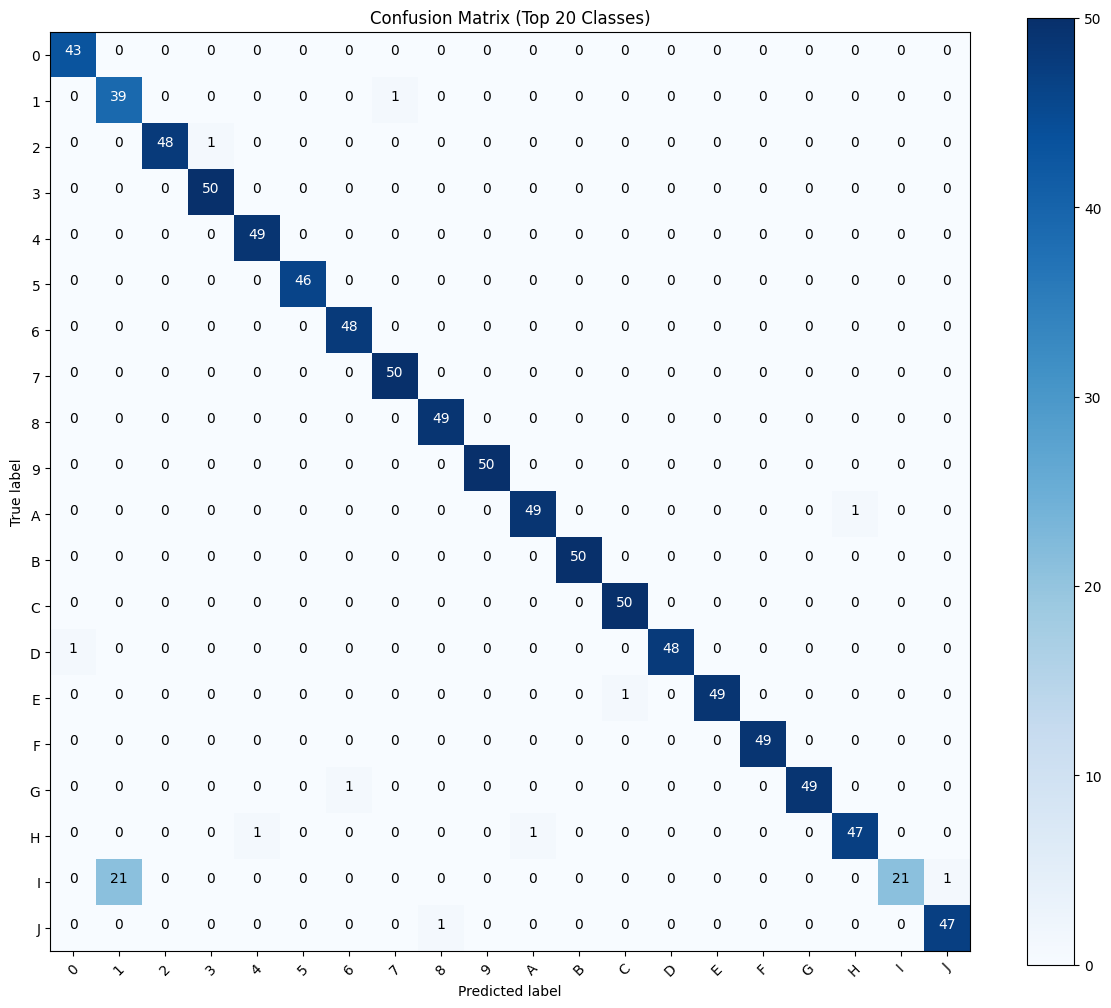

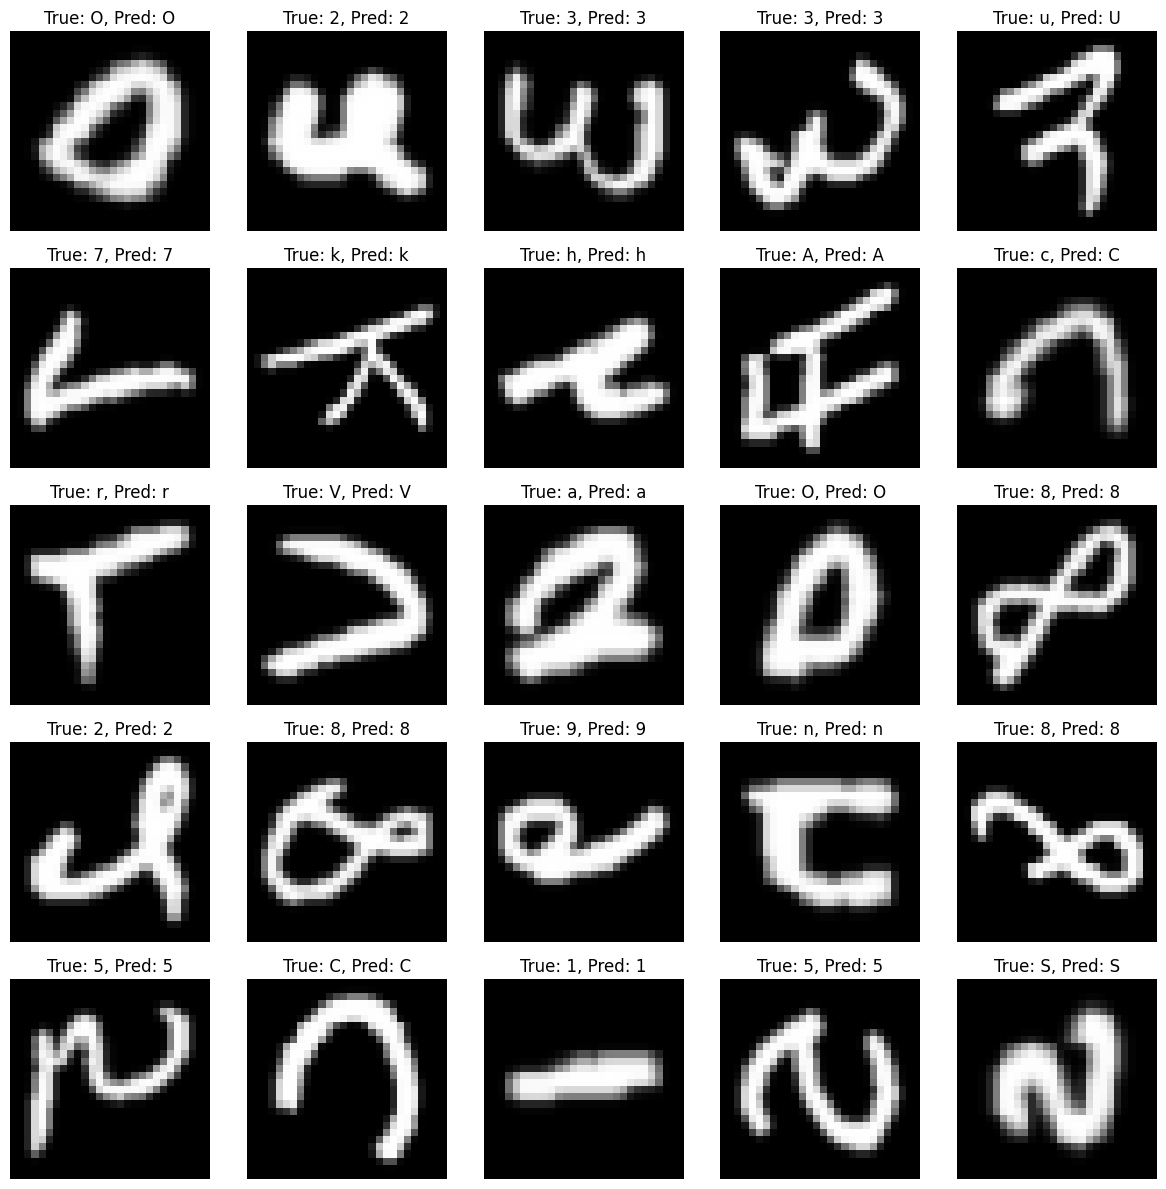

Plotting training history...


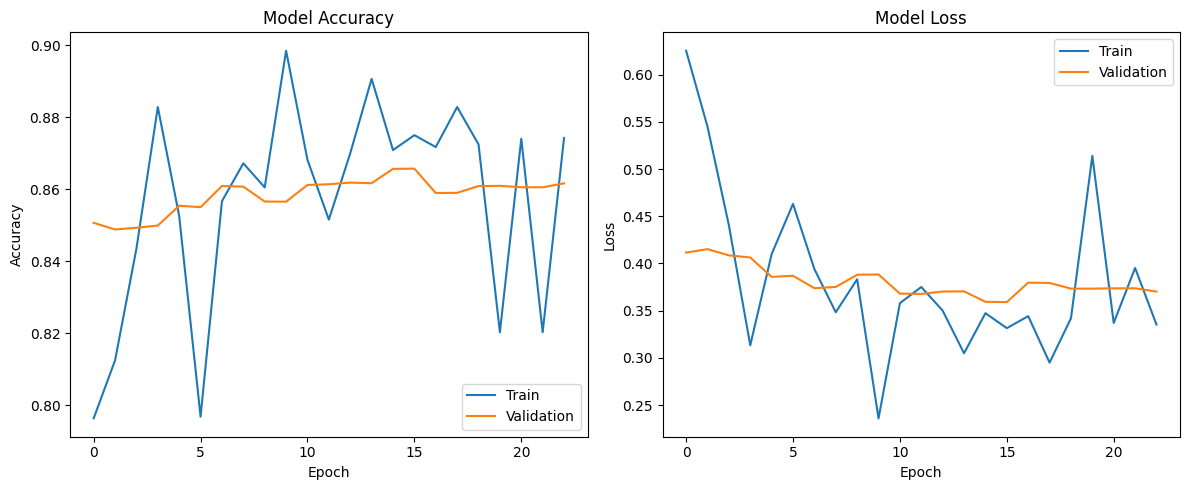

Saving model...
Model saved to handwritten_recognition_model.h5
Done!


In [ ]:
model, history, test_acc = main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: 33
Confidence: 99.60%


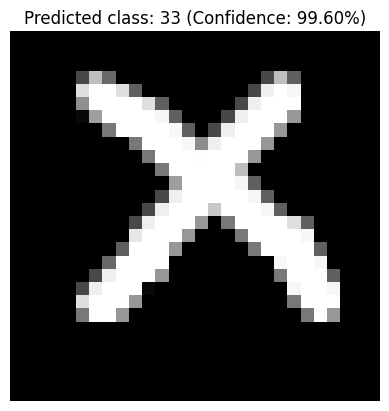

(np.int64(33), np.float32(99.595))

In [ ]:
predict_image(model,'/content/images/X1.png')

In [ ]:
get_class_mapping()

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'c',
 39: 'd',
 40: 'e',
 41: 'f',
 42: 'g',
 43: 'h',
 44: 'i',
 45: 'j',
 46: 'k',
 47: 'l',
 48: 'm',
 49: 'n',
 50: 'o',
 51: 'p',
 52: 'q',
 53: 'r',
 54: 's',
 55: 't',
 56: 'u',
 57: 'v',
 58: 'w',
 59: 'x',
 60: 'y',
 61: 'z'}